In [18]:
import re
import string
from pathlib import Path
from typing import Dict, Any, Union

import joblib
import numpy
from matplotlib import pyplot as plt
from numpy import asarray, average, dtype, ndarray
from pandas import read_csv
from scipy.stats import randint
from sklearn.ensemble import RandomForestClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.metrics import roc_curve, balanced_accuracy_score, auc
from sklearn.model_selection import cross_val_score, train_test_split, RandomizedSearchCV
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from tqdm.contrib.itertools import product


In [32]:
# Constant Numbers
CV = 5
OVERWRITE = False
RANDOM_STATE = 42
TEST_SIZE = 2e-1

# Paths
GLOVE_6B_50D_TXT = Path('models/glove.6B/glove.6B.50d.txt')
GLOVE_6B_100D_TXT = Path('models/glove.6B/glove.6B.100d.txt')
GLOVE_6B_200D_TXT = Path('models/glove.6B/glove.6B.200d.txt')
GLOVE_6B_300D_TXT = Path('models/glove.6B/glove.6B.300d.txt')
GLOVE_42B_300D_TXT = Path('models/glove.42B/glove.42B.300d.txt')
GLOVE_840B_300D_TXT = Path('models/glove.840B/glove.840B.300d.txt')
GLOVE_TWITTER_27B_25D_TXT = Path('models/glove.twitter.27B/glove.twitter.27B.25d.txt')
GLOVE_TWITTER_27B_50D_TXT = Path('models/glove.twitter.27B/glove.twitter.27B.50d.txt')
GLOVE_TWITTER_27B_100D_TXT = Path('models/glove.twitter.27B/glove.twitter.27B.100d.txt')
GLOVE_TWITTER_27B_200D_TXT = Path('models/glove.twitter.27B/glove.twitter.27B.200d.txt')

MODELS_DICT_PKL = Path('models/models_dict.pkl')
OPTIMAL_MODEL_PKL = Path('models/optimal_model.pkl')

THREAT_TWEETS_JSON = Path('data/threat.tweets.json')

ANASTASIA_CSV = Path('data/anastasia.csv')
THREAT_TWEETS_CSV = Path('data/threat.tweets.csv')


In [3]:
MODELS_INFO = [
    {'name': 'GloVe.6B.50D', 'model-path': GLOVE_6B_50D_TXT, 'embedding-dim': 50},
    {'name': 'GloVe.6B.100D', 'model-path': GLOVE_6B_100D_TXT, 'embedding-dim': 100},
    {'name': 'GloVe.6B.200D', 'model-path': GLOVE_6B_200D_TXT, 'embedding-dim': 200},
    {'name': 'GloVe.6B.300D', 'model-path': GLOVE_6B_300D_TXT, 'embedding-dim': 300},
    #{'name': 'GloVe.42B.300D', 'model-path': GLOVE_42B_300D_TXT, 'embedding-dim': 300},
    #{'name': 'GloVe.840B.300D', 'model-path': GLOVE_840B_300D_TXT, 'embedding-dim': 300},
    {'name': 'GloVe.Twitter.27B.25D', 'model-path': GLOVE_TWITTER_27B_25D_TXT, 'embedding-dim': 25},
    {'name': 'GloVe.Twitter.27B.50D', 'model-path': GLOVE_TWITTER_27B_50D_TXT, 'embedding-dim': 50},
    {'name': 'GloVe.Twitter.27B.100D', 'model-path': GLOVE_TWITTER_27B_100D_TXT, 'embedding-dim': 100},
    {'name': 'GloVe.Twitter.27B.200D', 'model-path': GLOVE_TWITTER_27B_200D_TXT, 'embedding-dim': 200}
]


In [4]:
def load_word2vec_dict(model_path: Path, embedding_dim: int) -> dict[Union[str, list[str]], ndarray[Any, dtype]]:
    embeddings_dict = {}

    f = open(model_path, 'r', encoding='utf-8')
    for line in f:
        values = line.split()
        word = values[:-embedding_dim]

        if type(word) is list:
            word = ' '.join(word)

        vector = asarray([float(val) for val in values[-embedding_dim:]])
        embeddings_dict[word] = vector
    f.close()

    return embeddings_dict


In [5]:
def preprocess_texts(texts, model_path, embedding_dim):
    word2vec_dict = load_word2vec_dict(
        model_path=model_path,
        embedding_dim=embedding_dim
    )
    x = numpy.zeros((len(texts), embedding_dim))
    for i, text in enumerate(texts):
        tokens = re.findall(r'\w+|[{}]'.format(re.escape(string.punctuation)), text)
        for token in tokens:
            try:
                x[i] += word2vec_dict[token.lower()]
            except KeyError:
                continue
    return x


In [6]:
def train_classifier(
        x: ndarray, y: ndarray, cv: int = 1, random_state: int = None, test_size: float = 0.2, model_type: str = None
) -> Dict[str, Union[float, Any]]:
    classifier_dict = {
        'cv-score': 0,
        'train-score': 0,
        'test-score': 0,
        'test-accuracy': 0,
        'roc-auc': 0,
        'model': None
    }

    if model_type == 'nb':
        estimator = GaussianNB()
    elif model_type == 'svm':
        estimator = SVC()
    elif model_type == 'rf':
        estimator = RandomForestClassifier(
            n_estimators=151,
            max_depth=15,
            min_samples_split=21,
            min_samples_leaf=10,
            bootstrap=False,
            random_state=RANDOM_STATE,
            verbose=0
        )
    elif model_type == 'mlp':
        estimator = MLPClassifier()
    elif model_type == 'dt':
        estimator = DecisionTreeClassifier()
    elif model_type == 'gp':
        estimator = GaussianProcessClassifier()
    else:
        return classifier_dict

    x_train, x_test, y_train, y_test = train_test_split(
        x, y,
        test_size=test_size,
        random_state=random_state,
        shuffle=True,
        stratify=y
    )

    classifier_dict['cv-score'] = average(a=cross_val_score(
        estimator=estimator,
        X=x,
        y=y,
        scoring='balanced_accuracy',
        cv=cv
    ))

    sc = StandardScaler()
    x_train = sc.fit_transform(x_train)
    x_test = sc.transform(x_test)

    estimator.fit(X=x_train, y=y_train)

    y_predicted = estimator.predict(X=x_test)
    fpr, tpr, _ = roc_curve(y_true=y_test, y_score=y_predicted)

    classifier_dict['train-score'] = estimator.score(X=x_train, y=y_train)
    classifier_dict['test-score'] = estimator.score(X=x_test, y=y_test)
    classifier_dict['test-accuracy'] = balanced_accuracy_score(
        y_true=y_test,
        y_pred=y_predicted
    )
    classifier_dict['fpr'] = fpr
    classifier_dict['tpr'] = tpr
    classifier_dict['roc-auc'] = auc(x=fpr, y=tpr)
    classifier_dict['model'] = estimator

    return classifier_dict


In [45]:
THREAT_TWEETS = read_csv(filepath_or_buffer=THREAT_TWEETS_CSV)
THREAT_TWEETS[(THREAT_TWEETS['type'] == 'vulnerability') & (THREAT_TWEETS['relevant'] == True)]

,_id,date,id,relevant,text,tweet,type,watson,annotation,urls,destination_url,valid_certificate
6,b'5b88770abb325e65fa7e78e7',2018-08-30 23:00:25+00:00,1035301242271096832,True,(good slides): \n\nThe Advanced Exploitation o...,{'created_at': 'Thu Aug 30 23:00:25 +0000 2018...,vulnerability,"{'usage': {'text_units': 1, 'text_characters':...",threat,['https://twitter.com/i/web/status/10353012422...,https://twitter.com/i/web/status/1035301242271...,True
7,b'5b887713bb325e65fa7e78e8',2018-08-30 23:00:35+00:00,1035301282095853569,True,CVE-2018-1000532 (beep)\nhttps://t.co/CaKbo38U...,{'created_at': 'Thu Aug 30 23:00:35 +0000 2018...,vulnerability,"{'usage': {'text_units': 1, 'text_characters':...",threat,['https://web.nvd.nist.gov/view/vuln/detail?vu...,https://nvd.nist.gov/vuln/detail/CVE-2018-1000532,True
12,b'5b887816bb325e65fa7e78ed',2018-08-30 23:04:53+00:00,1035302366273257472,True,OpenSSH vulnerability affecting all versions b...,{'created_at': 'Thu Aug 30 23:04:53 +0000 2018...,vulnerability,"{'usage': {'text_units': 1, 'text_characters':...",threat,['https://lnkd.in/fuU3BPk'],https://lnkd.in/fuU3BPk,True
13,b'5b88781dbb325e65fa7e78ee',2018-08-30 23:05:00+00:00,1035302394148601857,True,law in Fiserv banking platform exposed persona...,{'created_at': 'Thu Aug 30 23:05:00 +0000 2018...,vulnerability,"{'usage': {'text_units': 1, 'text_characters':...",threat,['https://hubs.ly/H0dByWm0'],https://www.itpro.com/vulnerability/31797/flaw...,True
25,b'5b887a29bb325e65fa7e78fa',2018-08-30 23:13:45+00:00,1035304594677460992,True,'Insight' into Home Automation Reveals Vulnera...,{'created_at': 'Thu Aug 30 23:13:45 +0000 2018...,vulnerability,"{'usage': {'text_units': 1, 'text_characters':...",threat,"['http://bit.ly/2wyOWAp', 'https://twitter.com...",https://www.mcafee.com:443/blogs/?utm_content=...,True
...,...,...,...,...,...,...,...,...,...,...,...,...
21337,b'5b98279ebb325e3cadebf98e',2018-09-11 20:37:43+00:00,1039613984628981761,True,These 2 Charts Show Citigroup's Greatest Vulne...,{'created_at': 'Tue Sep 11 20:37:43 +0000 2018...,vulnerability,"{'usage': {'text_units': 1, 'text_characters':...",threat,['http://ugz.me/IsXNWrlw'],http://ugz.me/IsXNWrlw,True
21338,b'5b9827d1bb325e3cadebf98f',2018-09-11 20:38:40+00:00,1039614224010493952,True,Google Hacked By Own Employee: Vulnerability F...,{'created_at': 'Tue Sep 11 20:38:40 +0000 2018...,vulnerability,"{'usage': {'text_units': 1, 'text_characters':...",threat,['https://www.techtimes.com/articles/234063/20...,https://www.techtimes.com/articles/234063/2018...,True
21340,b'5b9827d7bb325e3cadebf991',2018-09-11 20:38:46+00:00,1039614248853364738,True,CVE-2018-11069\n\nRSA BSAFE SSL-J versions pri...,{'created_at': 'Tue Sep 11 20:38:46 +0000 2018...,vulnerability,"{'usage': {'text_units': 1, 'text_characters':...",threat,['https://twitter.com/i/web/status/10396142488...,https://twitter.com/i/web/status/1039614248853...,True
21362,b'5b982920bb325e3cadebf9ac',2018-09-11 20:44:13+00:00,1039615619623280640,True,Incredibly powerful presentation by @rlovell10...,{'created_at': 'Tue Sep 11 20:44:13 +0000 2018...,vulnerability,"{'usage': {'text_units': 1, 'text_characters':...",threat,['https://twitter.com/i/web/status/10396156196...,https://twitter.com/i/web/status/1039615619623...,True


In [42]:
THREAT_TWEETS['watson'][]

0        {'usage': {'text_units': 1, 'text_characters':...
1        {'usage': {'text_units': 1, 'text_characters':...
2        {'usage': {'text_units': 1, 'text_characters':...
3        {'usage': {'text_units': 1, 'text_characters':...
4        {'usage': {'text_units': 1, 'text_characters':...
                               ...                        
21363    {'usage': {'text_units': 1, 'text_characters':...
21364    {'usage': {'text_units': 1, 'text_characters':...
21365    {'usage': {'text_units': 1, 'text_characters':...
21366    {'usage': {'text_units': 1, 'text_characters':...
21367    {'usage': {'text_units': 1, 'text_characters':...
Name: watson, Length: 21368, dtype: object

In [7]:
TEXTS = THREAT_TWEETS['text']
TARGET = THREAT_TWEETS['relevant']

CLASSIFIERS = []

if MODELS_DICT_PKL.exists():
    models_dict = joblib.load(MODELS_DICT_PKL)
else:
    models_dict = {}

for (item, classifier) in product(MODELS_INFO, CLASSIFIERS):
    X = preprocess_texts(
        texts=TEXTS,
        model_path=item['model-path'],
        embedding_dim=item['embedding-dim']
    )
    model_name = f"{classifier.upper()} {item['name']}"
    if OVERWRITE:
        model_dict = train_classifier(
            x=X,
            y=TARGET,
            cv=CV,
            random_state=RANDOM_STATE,
            test_size=TEST_SIZE,
            model_type=classifier
        )
        if model_dict['cv-score'] > models_dict[model_name]['cv-score']:
            models_dict[model_name] = model_dict
        print(f"· {classifier.upper()} {item['name']} - CS Score:\t{models_dict[model_name]['cv-score']:.2f}%")


0it [00:00, ?it/s]

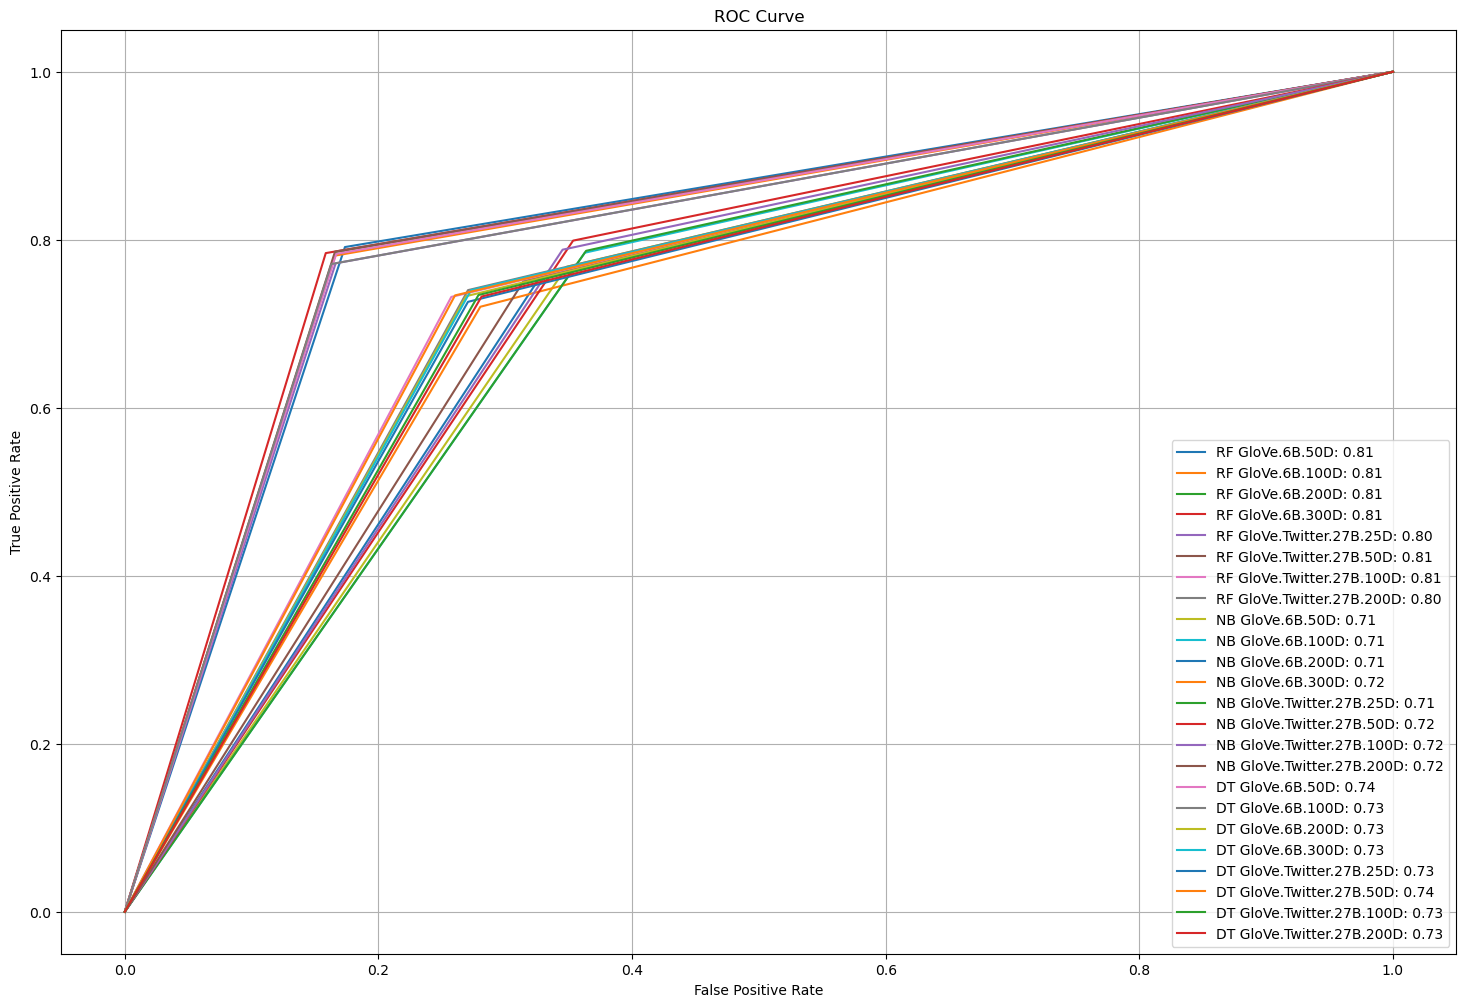

In [8]:
plt.figure(figsize=(18, 12))

for name, model_dict in models_dict.items():
    plt.plot(
        model_dict['fpr'], model_dict['tpr'],
        label=f'{name}: {model_dict["roc-auc"]:.2f}'
    )

plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.grid(True)
plt.show()


In [9]:
MAX_CV_SCORE = 0.
OPTIMAL_MODEL = None

for name, model in models_dict.items():
    if models_dict[name]['cv-score'] > MAX_CV_SCORE:
        MAX_CV_SCORE = models_dict[name]['cv-score']
        OPTIMAL_MODEL = model
        OPTIMAL_MODEL['name'] = name

OPTIMAL_MODEL


{'cv-score': 0.7686267303011611,
 'train-score': 0.9646659646659647,
 'test-score': 0.8116518483855872,
 'test-accuracy': 0.8128081426985684,
 'fpr': array([0.        , 0.15845929, 1.        ]),
 'tpr': array([0.        , 0.78407557, 1.        ]),
 'roc-auc': 0.8128081426985684,
 'model': RandomForestClassifier(),
 'name': 'RF GloVe.6B.300D'}

In [10]:
joblib.dump(OPTIMAL_MODEL, OPTIMAL_MODEL_PKL, compress=9)
MODEL = joblib.load(OPTIMAL_MODEL_PKL)
MODEL


{'cv-score': 0.7686267303011611,
 'train-score': 0.9646659646659647,
 'test-score': 0.8116518483855872,
 'test-accuracy': 0.8128081426985684,
 'fpr': array([0.        , 0.15845929, 1.        ]),
 'tpr': array([0.        , 0.78407557, 1.        ]),
 'roc-auc': 0.8128081426985684,
 'model': RandomForestClassifier(),
 'name': 'RF GloVe.6B.300D'}

In [11]:
joblib.dump(models_dict, MODELS_DICT_PKL, compress=9)


['models/models_dict.pkl']

In [40]:
DATA

NameError: name 'DATA' is not defined

In [31]:
# Default Random Forest
estimator = RandomForestClassifier(
    n_estimators=151,
    max_depth=15,
    min_samples_split=21,
    min_samples_leaf=10,
    bootstrap=False,
    random_state=RANDOM_STATE,
    verbose=0
)

x_train, x_test, y_train, y_test = train_test_split(
    preprocess_texts(
        texts=TEXTS,
        model_path=GLOVE_6B_300D_TXT,
        embedding_dim=300
    ), TARGET,
    test_size=TEST_SIZE,
    random_state=RANDOM_STATE,
    shuffle=True,
    stratify=TARGET
)

sc = StandardScaler()
x_train = sc.fit_transform(x_train)
x_test = sc.transform(x_test)

# Fit model
estimator.fit(X=x_train, y=y_train)

# Assess Performance
y_predicted = estimator.predict(X=x_test)
fpr, tpr, _ = roc_curve(y_true=y_test, y_score=y_predicted)
train_score = estimator.score(X=x_train, y=y_train)
test_score = estimator.score(X=x_test, y=y_test)
test_accuracy = balanced_accuracy_score(
    y_true=y_test,
    y_pred=y_predicted
)
roc_auc = auc(x=fpr, y=tpr)

# Best AUC score
print(f'AUC Score: {roc_auc:.2f}')


Best AUC Score: 0.81


# Performance sul dataset di Anastasia

In [36]:
ANASTASIA = read_csv(filepath_or_buffer=ANASTASIA_CSV)
ANASTASIA['RF.GloVe.6B.300D'] = estimator.predict(X=preprocess_texts(
    texts=ANASTASIA['full_text'],
    model_path=GLOVE_6B_300D_TXT,
    embedding_dim=300
))
rf_accuracy = balanced_accuracy_score(
    y_true=ANASTASIA['Related'],
    y_pred=ANASTASIA['RF.GloVe.6B.300D']
)
print(f"Accuracy of prediction over Anastasia's dataset is:\t{rf_accuracy:.2f}")


Accuracy of prediction over Anastasia's dataset is:	0.85


In [39]:
fpr, tpr, _ = roc_curve(y_true=ANASTASIA['Related'], y_score=ANASTASIA['RF.GloVe.6B.300D'])
roc_auc = auc(x=fpr, y=tpr)
print(f'AUC Score: {roc_auc:.2f}')


AUC Score: 0.85


In [37]:
OPTIMAL_MODEL = estimator
joblib.dump(OPTIMAL_MODEL, OPTIMAL_MODEL_PKL, compress=9)
MODEL = joblib.load(OPTIMAL_MODEL_PKL)
MODEL


RandomForestClassifier(bootstrap=False, max_depth=15, min_samples_leaf=10,
                       min_samples_split=21, n_estimators=151, random_state=42)

In [ ]:
#TODO: ORGANIZZA TABELLA